# Neural network 4 emotions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, callbacks, activations, regularizers
import numpy as np

2023-06-13 22:34:25.839461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def plot_results(hist):
  fig, axs = plt.subplots(1, 2, figsize=(25, 8))
  axs[0].plot(hist.history['loss'], label='loss')
  axs[0].plot(hist.history['val_loss'], label='val_loss')
  axs[1].plot(hist.history['accuracy'], label='accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='val_accuracy')

  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].grid(True)

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].grid(True)

Load and scale data
Change labels to numerical values
Remove highly correlated features
Create train, validation and test splits

In [4]:
# loading the data
dataset = pd.read_csv('../dataset/labeled_4_combined_dataset.csv', index_col=0)

# getting unique labels
unique_labels = np.unique(dataset['LABEL'])
unique_labels

array(['Ekscytacja', 'Odprezenie', 'Smutek', 'Zlosc'], dtype=object)

In [5]:
# changing labels to numerical
dataset.loc[dataset['LABEL'] == 'Ekscytacja', 'LABEL'] = 0.0
dataset.loc[dataset['LABEL'] == 'Odprezenie', 'LABEL'] = 1.0
dataset.loc[dataset['LABEL'] == 'Smutek', 'LABEL'] = 2.0
dataset.loc[dataset['LABEL'] == 'Zlosc', 'LABEL'] = 3.0

In [6]:
# separating data and labels
data = dataset.iloc[:, :-4]
labels = dataset.iloc[:, -1]
labels = np.asarray(labels).astype('float32')

# scaling the data
data_scaled = StandardScaler().fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# removing correlated features
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data.drop(to_drop, axis=1, inplace=True)

# creating train, validation and test splits
d, data_test, l, labels_test = train_test_split(data_scaled, labels, test_size=0.1, random_state=0, stratify=labels)
data_train, data_validation, labels_train, labels_validation = train_test_split(d, l, test_size=0.1, random_state=0, stratify=l)

In [7]:
BaseDense = partial(
    layers.Dense,
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=96, restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=32)

# ECG

Extract only ecg related features

In [8]:
ecg_columns = [col for col in data.columns if 'ECG' in col or 'HRV' in col]

ecg_data_train = data_train[ecg_columns]
ecg_data_validation = data_validation[ecg_columns]
ecg_data_test = data_test[ecg_columns]

Define the model and train it

Epoch 1/1000


2023-06-13 22:34:45.146391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 22:34:45.776535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3353 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-13 22:34:46.887372: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f649b57c880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-13 22:34:46.887413: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-06-13 22:34:46.957849: I tensorflow/compile

134/134 [==============================] - 2s 7ms/step - loss: 2.7229 - accuracy: 0.3073 - val_loss: 2.3285 - val_accuracy: 0.3197 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 1s 6ms/step - loss: 2.1102 - accuracy: 0.3149 - val_loss: 1.9205 - val_accuracy: 0.3081 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 1s 7ms/step - loss: 1.7938 - accuracy: 0.3155 - val_loss: 1.6874 - val_accuracy: 0.3165 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 1s 7ms/step - loss: 1.6108 - accuracy: 0.3200 - val_loss: 1.5494 - val_accuracy: 0.2976 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 1s 7ms/step - loss: 1.5046 - accuracy: 0.3289 - val_loss: 1.4713 - val_accuracy: 0.3007 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.4429 - accuracy: 0.3266 - val_loss: 1.4255 - val_accuracy: 0.3155 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 1s 5ms/step - l

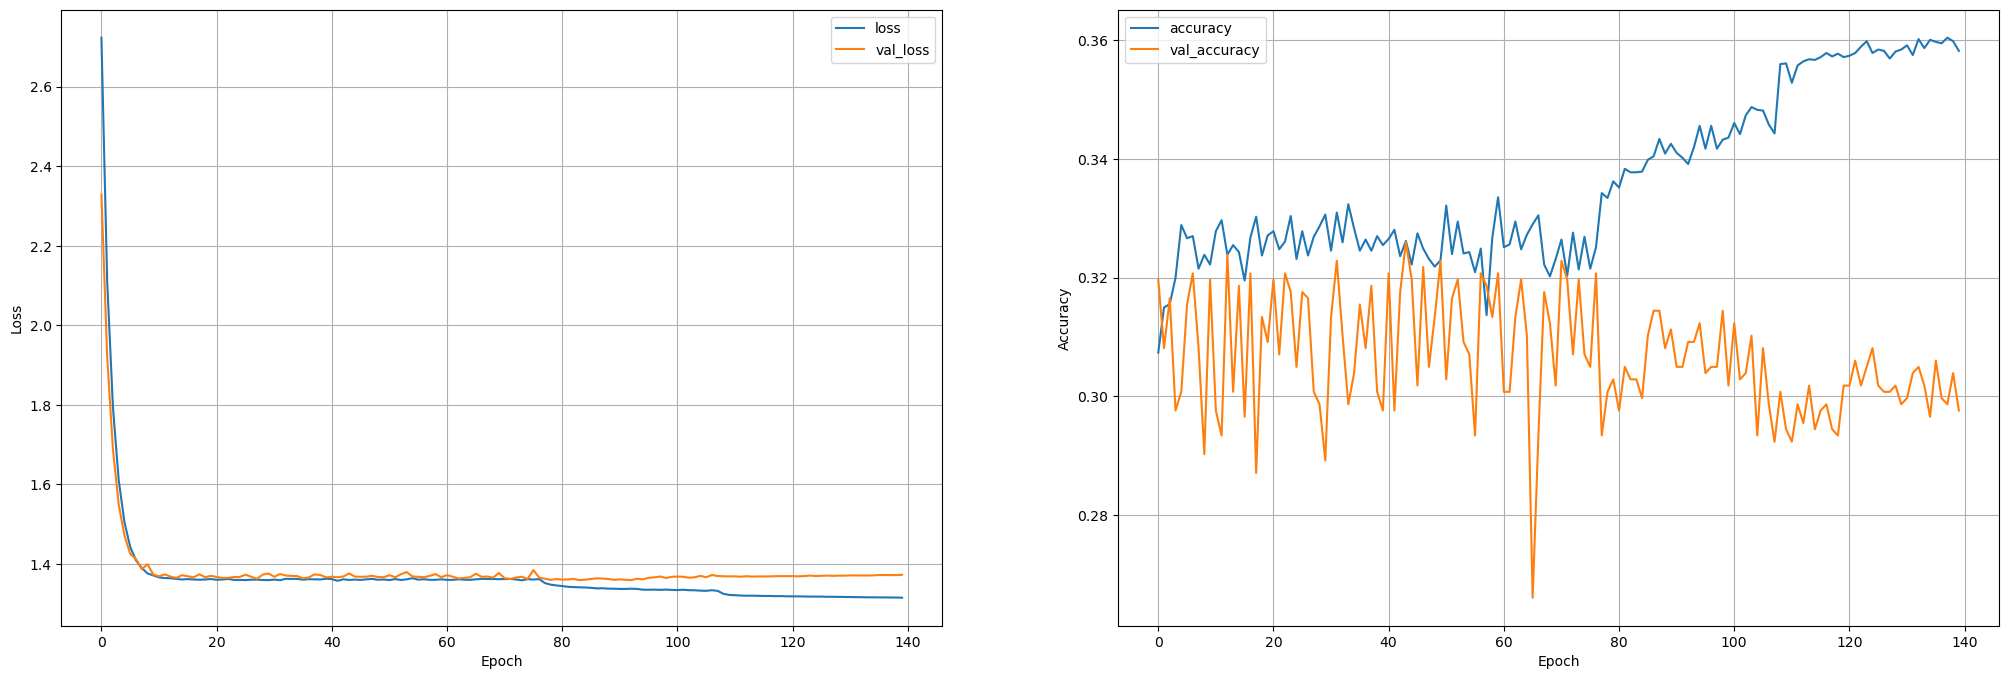

In [9]:
ecg_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

ecg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = ecg_model.fit(
    ecg_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(ecg_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [36]:
ecg_predictions = np.argmax(ecg_model.predict(ecg_data_test), axis=1)

ecg_cr = classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.3654    0.0619    0.1058       307
  Odprezenie     0.0000    0.0000    0.0000       181
      Smutek     0.3263    0.9617    0.4873       339
       Zlosc     0.3333    0.0087    0.0169       230

    accuracy                         0.3283      1057
   macro avg     0.2563    0.2581    0.1525      1057
weighted avg     0.2833    0.3283    0.1907      1057



# EDA

Extract only eda related features

In [37]:
eda_columns = [col for col in data.columns if 'EDA' in col or 'SCR' in col]

eda_data_train = data_train[eda_columns]
eda_data_validation = data_validation[eda_columns]
eda_data_test = data_test[eda_columns]

Define the model and train it

Epoch 1/1000
134/134 [==============================] - 2s 9ms/step - loss: 2.7051 - accuracy: 0.3113 - val_loss: 2.3234 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 1s 6ms/step - loss: 2.1062 - accuracy: 0.3170 - val_loss: 1.9186 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.7928 - accuracy: 0.3064 - val_loss: 1.6785 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 1s 6ms/step - loss: 1.6086 - accuracy: 0.3130 - val_loss: 1.5411 - val_accuracy: 0.3228 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.5026 - accuracy: 0.3160 - val_loss: 1.4681 - val_accuracy: 0.3207 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 1s 6ms/step - loss: 1.4425 - accuracy: 0.3158 - val_loss: 1.4183 - val_accuracy: 0.3218 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 1s

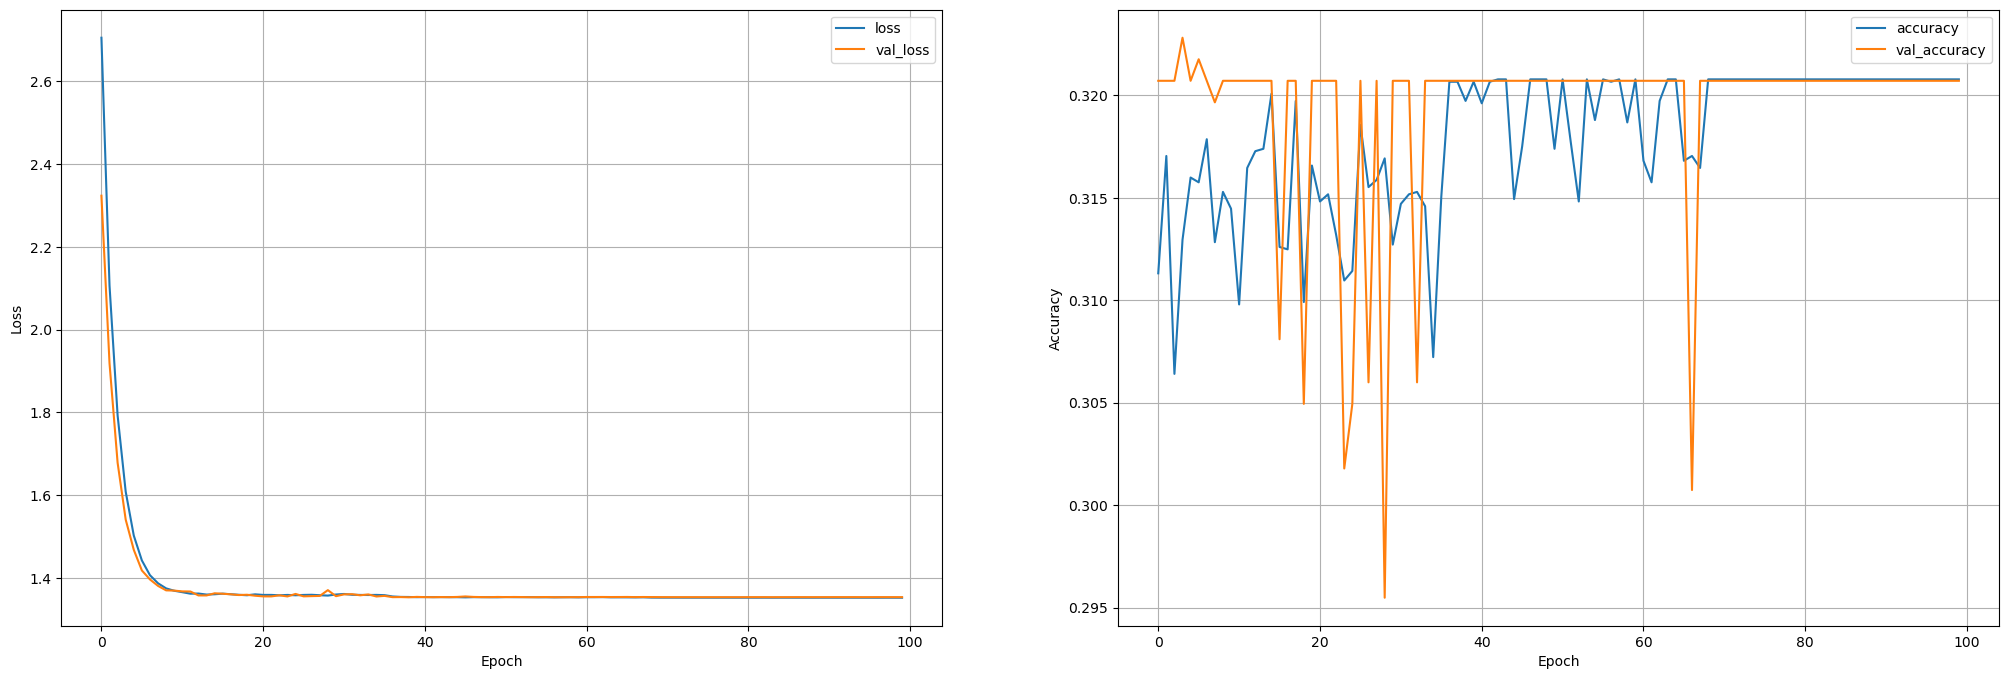

In [38]:
eda_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

eda_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = eda_model.fit(
    eda_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(eda_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [39]:
eda_predictions = np.argmax(eda_model.predict(eda_data_test), axis=1)

eda_cr = classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.0000    0.0000    0.0000       307
  Odprezenie     0.0000    0.0000    0.0000       181
      Smutek     0.3207    1.0000    0.4857       339
       Zlosc     0.0000    0.0000    0.0000       230

    accuracy                         0.3207      1057
   macro avg     0.0802    0.2500    0.1214      1057
weighted avg     0.1029    0.3207    0.1558      1057



# Combined

Epoch 1/1000
134/134 [==============================] - 2s 6ms/step - loss: 2.6762 - accuracy: 0.3118 - val_loss: 2.3034 - val_accuracy: 0.3197 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 1s 5ms/step - loss: 2.0903 - accuracy: 0.3186 - val_loss: 1.9089 - val_accuracy: 0.3197 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.7795 - accuracy: 0.3271 - val_loss: 1.6833 - val_accuracy: 0.3197 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.6020 - accuracy: 0.3253 - val_loss: 1.5438 - val_accuracy: 0.3270 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.4994 - accuracy: 0.3262 - val_loss: 1.4733 - val_accuracy: 0.3070 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 1s 5ms/step - loss: 1.4406 - accuracy: 0.3352 - val_loss: 1.4260 - val_accuracy: 0.3102 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 1s

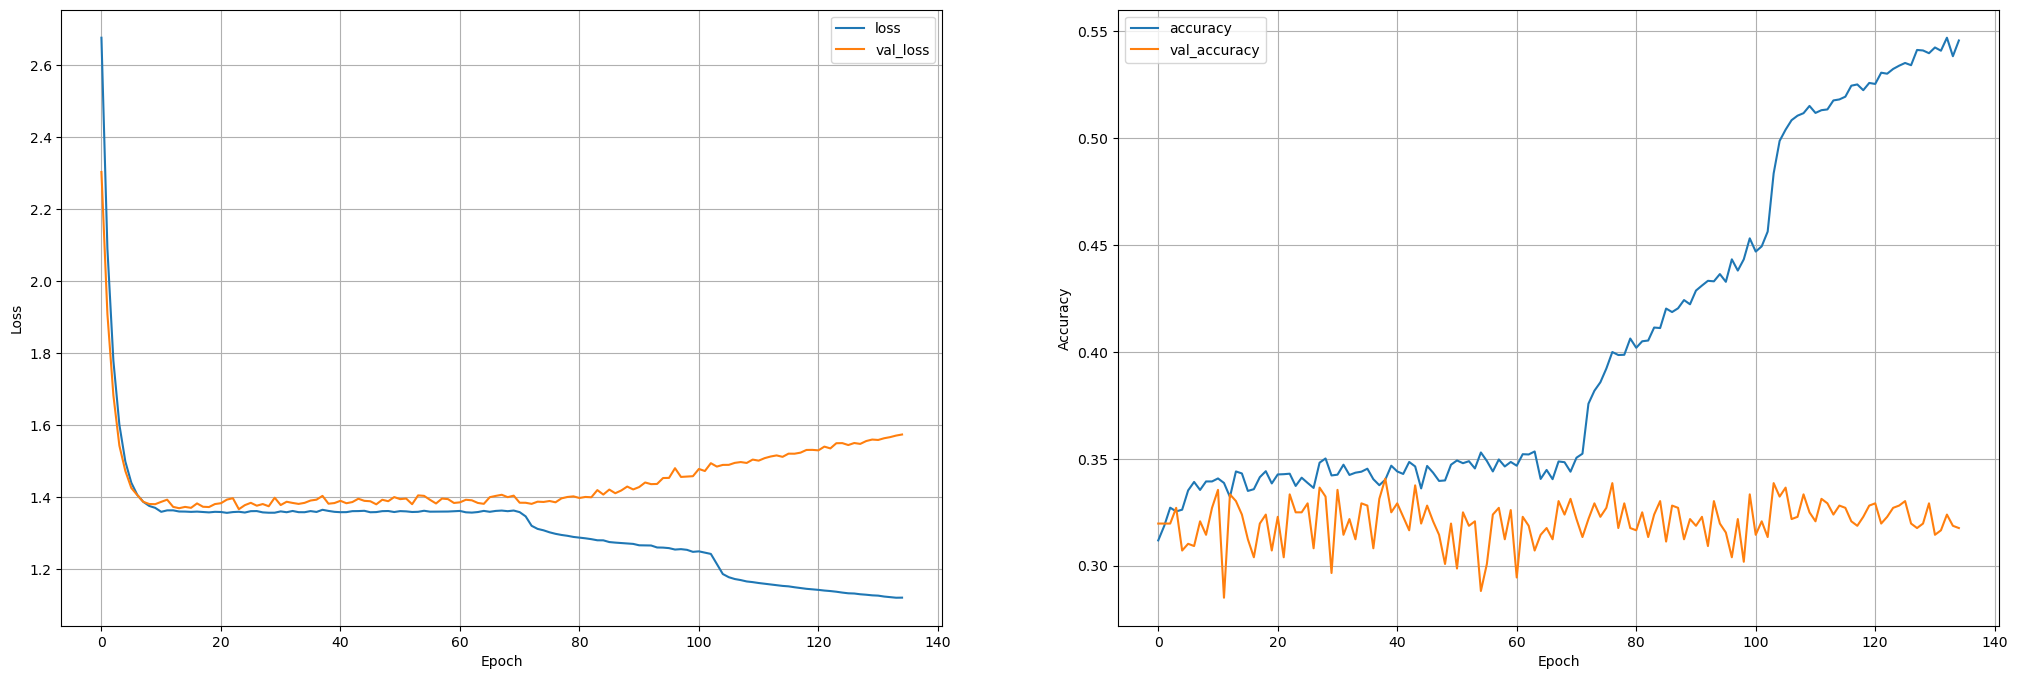

In [40]:
model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = model.fit(
    data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [41]:
predictions = np.argmax(model.predict(data_test), axis=1)

cr = classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.3274    0.1205    0.1762       307
  Odprezenie     0.1250    0.0110    0.0203       181
      Smutek     0.3430    0.8053    0.4811       339
       Zlosc     0.2955    0.1696    0.2155       230

    accuracy                         0.3321      1057
   macro avg     0.2727    0.2766    0.2233      1057
weighted avg     0.2908    0.3321    0.2558      1057



# Summary

In [42]:
print(f'''
\tAccuracy:
ECG:\t{ecg_cr['accuracy']}
EDA:\t{eda_cr['accuracy']}
Both:\t{cr['accuracy']}
\tAverage F1:
ECG:\t{ecg_cr['macro avg']['f1-score']}
EDA:\t{eda_cr['macro avg']['f1-score']}
Both:\t{cr['macro avg']['f1-score']}
\tWeighted F1:
ECG:\t{ecg_cr['weighted avg']['f1-score']}
EDA:\t{eda_cr['weighted avg']['f1-score']}
Both:\t{cr['weighted avg']['f1-score']}
''')


	Accuracy:
ECG:	0.3282876064333018
EDA:	0.3207190160832545
Both:	0.33207190160832545
	Average F1:
ECG:	0.1525233010180811
EDA:	0.12141833810888251
Both:	0.22325548167513262
	Weighted F1:
ECG:	0.19071613237830926
EDA:	0.15576467973097888
Both:	0.25582027269694374

